# Partial differential equations

Requirements
+ matplotlib
+ numpy
+ scipy

Optional
+ ipywidgets (for making interactive visualizations)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Phase separation, initial value problems, and the Method of Lines

### The Allen-Cahn equation

We want to solve [the Allen-Cahn equation](https://www.sciencedirect.com/science/article/abs/pii/0001616072900375), a single-variable partial differential equation describing spontaneous mixture or separation of two components of a binary mixture, such as two metals in an alloy. This initial value problem is what's known as a parabolic differential equation, because it contains derivatives that are first-order in time and second-order in space.
$$
\dot{\rho}(\mathbf{r}, t) = D \nabla^2 \rho(\mathbf{r}, t) + \kappa \rho(\mathbf{r}, t) (1 - \rho(\mathbf{r}, t)^2),
$$
where the scalar field $\rho$ denotes the relative concentration of the two alloys at a given region of space, the constant $D$ denotes the diffusivity of the scalar field $\rho(\mathbf{r}, t)$, and $\kappa$ determines the degree by which the two fluids avoid mixing with eachother (this loosely corresponds to surface tension).

Notice that, when $\kappa = 0$, this problem reduces to the heat equation. Conversely, when $D = 0$, we no longer have any spatial structure in the problem, and can solve it as though it were an ODE. We can thus see that there are two competing terms in the AC equation:  The diffusion term penalizes gradients and causes the two mixtures to intermix over time, because diffusion penalizes inhomogeneity. However, this term competes with the reaction term, which encourages the majority mixture component at a given point to exclude the other component.

In order to solve this equation, we need to specify the initial conditions. For ordinary differential equations $\dot{\mathbf{x}}(t) = \mathbf{f}(\mathbf{x}(t), t)$, an initial value problem consists of specifying the initial conditions $\mathbf{x}(0)$, and then solving for $\mathbf{x}(t)$ at future times $t$. For a PDE, solving an initial value problem requires specifying the initial value of a scalar field $\rho(\mathbf{r}, 0)$ and then solving for the future field configuration.

### Numerical approach

Our approach will be *the method of lines.* This semi-discretization approach consists of first explicitly discretizing the spatial part of the differential equation, thereby reducing the problem to solving a set of coupled ODEs describing each lattice site at a given time. Like the heat equation, the only portion of the equation that couples together different spatial lattice sites is the Laplace operator, and so we seek a discrete approximation of this term in the equation.

If we assume that we are working in two-dimensions, then the semi-discretization consists of replacing $\rho(\mathbf{r}, t)$ with $\rho_{ij}(t)$, which denotes the lattice site at location $i$ and $j$ on a square lattice. We therefore can approximate the Laplace operator using first-order central finite differences,
$$
\nabla^2 \rho(\mathbf{r}, t) \approx (\rho_{i + 1, j}(t) - 2 \rho_{ij}(t) + \rho_{i - 1, j}) + (\rho_{i, j + 1}(t) - 2 \rho_{ij}(t) + \rho_{i, j - 1}(t))      \\
\nabla^2 \rho(\mathbf{r}, t) \approx \rho_{i + 1, j}(t) + \rho_{i, j + 1}(t) - 4 \rho_{ij}(t) + \rho_{i - 1, j}(t) + \rho_{i, j - 1}(t)
$$
Where we have used the fact that we are working in Cartesian coordinates $\nabla^2 = \dfrac{\partial^2}{\partial x^2} + \dfrac{\partial^2}{\partial y^2}$ in order to sum the one-dimensional discrete Laplace operators. The method of lines is one member of a general family of **finite-difference methods** for partial differential equations, where we convert derivatives in space in time into discrete difference equations.

### Putting it all together

We can can now write the Allen-Cahn equation in terms of our discrete Laplace operator,
$$
\dot{\rho}_{ij}(t) = D\left(\rho_{i + 1, j}(t) + \rho_{i, j + 1}(t) - 4 \rho_{ij}(t) + \rho_{i - 1, j}(t) + \rho_{i, j - 1}(t)\right) + \kappa \rho_{ij}(t) (1 - \rho_{ij}(t)^2)
$$

This equation basically specifies a set of coupled ordinary differential equations, where individual equations are specified by two indices $ij$ instead of a single index. All that we need to do now is discretize the initial values of the field, by sampling its values at the different lattice sites: $\rho(\mathbf{r}, 0) \rightarrow \rho_{ij}(0)$. We can then proceed by solving the system of coupled ordinary differential equations using the exact same methods we normally use to solve systems of ODEs.

### Boundary Conditions

One ambiguity that we need to resolve will be our choice of boundary conditions---what happens at the edges of our solution domain? If our indices $i$ and $j$ have values $i,j \in \{0, 1, ..., N\}$, then we need a principled choice for the behavior of the discrete Laplace operator when $i,j < 0$ or $i, j > N$. 

Depending on the type of problem, boundary conditions for partial differential equations can often be classified as either:
1. Dirichlet: the value of $\rho$ is specified on the boundary.
2. Neumann: the value of $\nabla \rho$ is specified on the boundary.

Dirichlet boundary conditions occur if a physical phenomenon "pins" the values of the scalar field at the edges of the domain. For example, in a partial differential equation describing deformations of a drumhead, the edges are usually pinned. Conversely, Neumann boundary conditions indicate the the flux of the field is pinned at the edges of the domain. For example, the edges of a granular pile have a preferred contact angle that they form with surfaces. However, mixtures of both types boundary conditions, as well as higher-order combinations, also exist. For example, in fluid dynamics we often encounter equations that obey a no-slip and no-flux boundary condition. The no-slip boundary condition specifies that the velocity of a fluid is always zero along a direction tangential to a boundary due to friction, thus representing a Dirichlet condition along the tangential direction. However, the no-flux boundary condition specifies that fluid cannot penetrate the boundary along the direction perpendicular to the boundary, thus representing a Neumann boundary condition.

### Problem outline

Now that we've discretized our equation and figured out our boundary conditions, we are ready to numerically solve the heat equation using the exact same tricks we used to solve ODEs. We can choose whatever ODE solver that we prefer, including Euler's method, Runge-Kutta, or even variable-step or implicit methods. Here, rather than worrying about our choice of solver, we are going to use the `scipy` package's built-in ODE solver `solve_ivp`, which provides a consistent API for a whole suite of different ODE solution methods.

We will use a square domain, and we will use a particular type of Neumann boundary conditions: reflection. We specify that the derivative of $\rho$ equal zero along all directions perpendicular to the boundary, $\nabla \rho \cdot \hat{\mathbf{n}} = 0$, where $\hat{\mathbf{n}}$ is the normal vector to the boundary. This is equivalent to assuming that the boundary doesn't exist, and all points beyond where it appears correspond to a mirror image of our field---since any finite difference across the reflection will vanish.

### To Do

1. Implement the Allen-Cahn equation using the method of lines. I recommend implementing just the diffusion portion first, and checking that it works, before adding on the reaction term. I've included an outline of my solution below. Once you've reduced the problem to a system of coupled ODEs, you will need to make generous use of `np.reshape`. For numerical integration, we will use the ODE solver `scipy.integrate.solve_ivp`. Review the API and docs for that function to make sure your diffential equation is set up properly. 
2. Describe how varying $D$ and $\kappa$ change the properties of your solution. Is this consistent with your intuition for special cases in which this equation is solvable?
3. Try changing the mesh size, integration timestep, or integration duration. Under what conditions does the solver fail? What do failures look like for this solution method?
4.  If you are familiar with Photoshop, you have probably used a tool called a ["Gaussian blur,"](https://www.youtube.com/watch?v=ri8RVzhHYoA) which blurs image details in a manner reminiscent of camera blur. This method is occasionally used in the analysis of experimental microscopy images, or even one-dimensional time series, in order to remove high-frequency information. The results of a Gaussian blur of fixed radius look very reminiscent of applying the raw diffusion equation ($\kappa=0$) to our initial conditions for a fixed duration. Based on what you know about analytical results for the heat equation, can you guess why this might be the case? What kind of photo-editing operation does the reaction term in our system mimic?


### Additional information

+ We used first-order central finite differences in order to resolve the derivatives. This will poll two lattice sites to compute a first derivative along a given direction, and it will poll three lattice sites in order to compute a second derivative. If we have a very dense mesh and desire higher accuracy, we are free to use a [higher-order approximation](https://en.wikipedia.org/wiki/Finite_difference_coefficient). On an uneven mesh, it may even make sense to adaptively choose the order of our approximation based on $\delta x$, the local lattice spacing.
+  The [Cahn-Hilliard equation](https://dspace.mit.edu/bitstream/handle/1721.1/100188/10-626-spring-2011/contents/lecture-notes/MIT10_626S11_lec38.pdf) is a more sophisticated model of phase separation, which appears more commonly in modern works. This equation contains higher order terms in $\nabla$ than the Allen-Cahn equation, allowing a richer range of dynamical behaviors, such as spinoidal decomposition  and critical opalescence.

In [7]:
from weakref import ref
from scipy.integrate import odeint, solve_ivp

class AllenCahn:
    """
    An implementation of the Allen-Cahn equation in two dimensions, using the method
    of lines and explicit finite differences

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        kappa (float): reaction rate
        d (float): diffusion coefficient
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction

    """

    def __init__(self, nx, ny, kappa=1.0, d=1.0, Lx=1.0, Ly=1.0):
        self.nx = nx
        self.ny = ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.d = d
        self.kappa = kappa
       
    def _laplace(self, grid):
        """
        Apply the two-dimensional Laplace operator to a square array
        """
        ddrho = grid.copy()
        ddrho[1:-1, 1:-1] = (grid[1:-1, :-2] + grid[1:-1, 2:] + grid[:-2, 1:-1] + grid[2:, 1:-1] - 4 * grid[1:-1, 1:-1]) / (self.dx * self.dy)

        # Enforce Neumann boundary conditions for the Laplacian for the four edges
        ddrho[0, 1:-1] = (grid[0, :-2] + grid[0, 2:] + 2*grid[1, 1:-1] - 4 * grid[0, 1:-1]) / (self.dx * self.dy)
        ddrho[-1, 1:-1] = (grid[-1, :-2] + grid[-1, 2:] + 2*grid[-2, 1:-1] - 4 * grid[-1, 1:-1]) / (self.dx * self.dy)
        ddrho[1:-1, 0] = (2*grid[1:-1, 1] + grid[:-2, 0] + grid[2:, 0] - 4 * grid[1:-1, 0]) / (self.dx * self.dy)
        ddrho[1:-1, -1] = (2*grid[1:-1, -2] + grid[:-2, -1] + grid[2:, -1] - 4 * grid[1:-1, -1]) / (self.dx * self.dy)

        # Enforce Neumann boundary conditions for the Laplacian for the four corners
        ddrho[0, 0] = (2*grid[0, 1] + 2*grid[1, 0] - 4 * grid[0, 0]) / (self.dx * self.dy)
        ddrho[0, -1] = (2*grid[0, -2] + 2*grid[1, -1] - 4 * grid[0, -1]) / (self.dx * self.dy)
        ddrho[-1, 0] = (2*grid[-1, 1] + 2*grid[-2, 0] - 4 * grid[-1, 0]) / (self.dx * self.dy)
        ddrho[-1, -1] = (2*grid[-1, -2] + 2*grid[-2, -1] - 4 * grid[-1, -1]) / (self.dx * self.dy)

        return ddrho

    def _reaction(self, grid):
        """
        Bistable reaction term
        """
        return (1-grid**2)*grid

    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        grid = y.reshape(self.nx, self.ny)
        rhs = self._laplace(grid)*self.d + self._reaction(grid)*self.kappa
        return rhs.flatten()



    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the odeint solver

        **kwargs are passed to scipy.integrate.solve_ivp
        """
        tpts = np.linspace(t_min, t_max, nt)
        out = solve_ivp(self.rhs, (t_min, t_max), y0.flatten(), t_eval=tpts, **kwargs)
        sol = out.y.T
        tpts =  out.t
        return tpts, sol.reshape((len(tpts), self.ny, self.nx))




### Test and use your code
You don't need to write any code below, these cells are just to confirm that everything is working and to play with your implementation

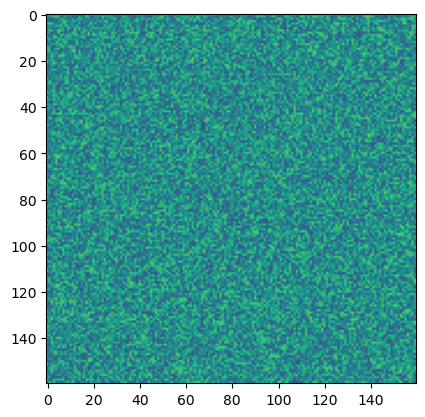

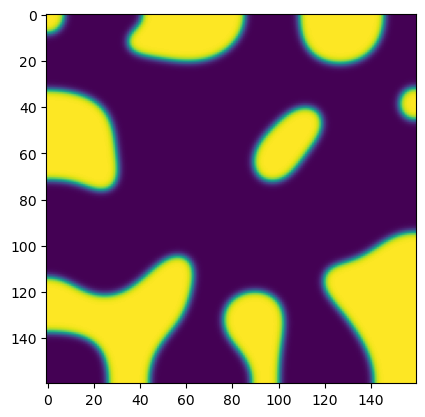

In [12]:
# import one of William's solutions
# from solutions.allencahn_spectral import AllenCahn
# from solutions.allencahn import AllenCahn

## Run an example simulation and plot the before and after
np.random.seed(0)
ic = np.random.random((160, 160)) - 0.5
model = AllenCahn(*ic.shape, kappa=1e1, d=5e-4)
tpts, sol = model.solve(ic, 0, 8, 400, method="DOP853")


plt.figure()
plt.imshow(sol[0], vmin=-1, vmax=1)

plt.figure()
plt.imshow(sol[-1], vmin=-1, vmax=1)

In [13]:
##  (optional) Make an interactive video with a slider in the notebook
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(sol[i], vmin=-1, vmax=1, cmap="coolwarm")
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(sol) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=399), Output()), _…

<function __main__.plotter(i)>

#### Extras

These are the utilities that William uses to make videos

In [ ]:
# (Optional) I use this code to export still images, and then make a video from them using
# the command-line tool ffmpeg


for i in range(len(sol)):
    plt.figure()
    plt.imshow(sol[i], vmin=-1, vmax=1, cmap="coolwarm")
    out_path = "private_dump/frame" + str(i).zfill(4) + ".png"


    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.02, dpi=160)
    plt.close()



In [ ]:
# (Optional) I used this code to stitch the images together into a video. The %%bash magic tells
# iPython to treat these lines as bash commands, rather than Python. I then use the 
# command-line tool `ffmpeg` to stitch the images together into a video.

%%bash
ffmpeg -r 60 -i private_dump/frame%04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -vcodec libx264 -pix_fmt yuv420p private_dump/vid2.mov


# Turing's model of morphogenesis and spectral methods

Reaction-diffusion equations are sets of partial differential equations describing interactions among multiple coupled fields. Each field's dynamical equation contains an interaction term with the other field, and a term describing diffusion of that field in space. Reaction diffusion equations appear in many contexts in physics, and they represent a protypical example of nonlinear partial differential equations where spatial effects give rise to unique bifurcations unobserved in similar ordinary differential equations.

Here, we are going to visit one of the most elegant known applications of reaction-diffusion dynamics: pattern formation. In 1952, Alan Turing used systems of reaction-diffusion equations to propose [a model of morphogenesis](https://www.dna.caltech.edu/courses/cs191/paperscs191/turing.pdf)--the process by which cheetahs get their spots, or leaves develop their unique shapes. While biological systems often give the impression that every detail of the patterns on a zebra or the plumage of a parrot is precisely programmed by an elaborate genetic circuit, Turing's model suggests that two interacting chemical fields created early during the development of an organism can spontaneously produce surprisingly natural patterns, as long as natural selection has lead the governing parameters in the underlying equations to have just the right values.

### The Gray-Scott model

The simplest example of reaction-diffusion equations producing Turing patterns is the Gray-Scott model, which describes a synthesis reaction between two chemical species $U$ and $V$:
$$
U + 2 V \rightarrow 3 V
$$
On a slower timescale, a second degradation reaction occurs in $V$
$$
V \rightarrow P
$$
Where $P$ is an inert byproduct of the reaction. During an organism's development, the "slow" variable $V$ might represent a diffusing signalling molecule, while the fast reaction variable $U$ my represent the activity level of a gene activated by the molecule. 

If this reaction occurs across a spatial domain, then we can write two scalar fields, $u(\mathbf{r}, t)$ and $v(\mathbf{r}, t)$ describing the concentrations of the two chemical species across space.
$$
\dot u = - u v^2 + b(1 - u) + D_u \nabla^2 u
$$
$$
\dot v = u v^2 - \kappa v + D_v \nabla^2 v
$$
where $D_u$ and $D_v$ indicate separate diffusivities for the two reagents, and $b$ and $\kappa$ parametrize autocatalysis of $U$ and degradation of $V$, respectively. If $U$ and $V$ were two chemical species, then separate diffusivities might result from the two having very different molecular weights.

### Spectral methods

Turing patterns have interesting mathematical structure because they reach steady-state solutions with nontrivial spatial heterogeneity in $u(\mathbf{r}), v(\mathbf{r})$. This setting represents a perfect use case for a class of PDE solvers known as [spectral methods](http://faculty.washington.edu/rjl/classes/am590a2013/_static/Fourier-Spectral.pdf), which seek to solve spatial PDEs in spatial frequency space rather than real space

The critical idea for spectral methods is to remember that the Fourier transform of the derivative of a function is proportional to a polynomial times the function in frequency space. Using the expanded notation for a Fourier transform $U(k) \equiv \mathcal{F}[u(x)](k)$, then $\mathcal{F}[\frac{\partial}{\partial x} u(x)](k) = i k U(k)$ and $\mathcal{F}[\frac{\partial^2}{\partial^2 x} u(x)](k) = - k^2 U(k)$. These identities give us a way to transform our Gray-Scott equations into a more favorable representation; first by taking the Fourier transform of both sides of our equations, and then exploiting the linear properties of the Fourier transform operator. We can write our Gray-Scott equations in frequency space as
$$
\dot U = -\mathcal{F}[u v^2 + b(1 - u)] - D_u k^2 U    \\
\dot V = \mathcal{F}[u v^2 - \kappa v] - D_v k^2 V
$$
Where we have used $U, V$ to denote the respective Fourier transforms of $u$ and $v$, $U \equiv \mathcal{F}[u], V \equiv \mathcal{F}[V]$. Hereafter, will use the condensed notation $\mathcal{F}[u(x)](k) \rightarrow \mathcal{F}[u]$. Because we want to write these equations exclusively in terms of our frequency-space dynamical variables $U$ and $V$, we re-write these equations as,
$$
\dot U = -\mathcal{F}[\mathcal{F^{-1}}[U] \mathcal{F^{-1}}[V]^2 + b(1 - \mathcal{F^{-1}}[U])] - D_u k^2 U    \\
\dot V = \mathcal{F}[\mathcal{F^{-1}}[U] \mathcal{F^{-1}}[V]^2 - \kappa \mathcal{F^{-1}}[V]] - D_v k^2 V
$$
This is a bit of an ugly way to write things out, but it emphasizes the computational steps.

In the Fourier domain, we've gotten rid of the pesky Laplace operator that slowed down our integration in our previous problem. The tradeoff is that the reaction term looks more difficult now. In order to numerically integrate this equation in $U, V$ space, we would need to constantly convert between real and frequency space every time we want to compute the reaction term. Another option would be to convert *back* to real space,
$$
\dot u = - u v^2 + b(1 - u) - \mathcal{F^{-1}}[D_u k^2 \mathcal{F}[u]]   \\
\dot v = u v^2 - \kappa v - \mathcal{F^{-1}}[D_v k^2 \mathcal{F}[v]]
$$

We can see now the key idea behind spectral methods: at each timestep, we switch to whatever basis (real space or frequency space) that makes it easiest to evaluate the terms in our dynamical equations. If we're working primarily in Fourier space, then we need to perform an inverse Fourier transform to calculate the real-space fields $u, v$, calculate the reaction, and then convert back to Fourier space. If we are working in real space, we need to perform a Fourier transfom to get $U, V$, calculate the diffusion term, and then perform an inverse Fourier transform to convert back to real space. If we were just solving an isolated diffusion equation, we could stay exclusively in Fourier space (likewise, real space for a purely reaction term). Unfortunately, we usually won't get so lucky for many real-world PDEs.

Why would performing two Fourier transforms per timestep possibly be worthwhile compared to using the discrete Laplace operator, as we did above? While performing two fast Fourier transforms per timestep clearly increases the runtime per timestep, the key advantage of spectral methods is that they are usually very stable for long simulations. We can therefore decrease our mesh size (the number of spatial points in our domain), and still get a solution with the same accuracy. So, while using spectral methods increases the runtime of a single iteration of the right hand side for a given mesh size, we get time back because we can evaluate on a much coarser domain---for example, we might be able to go from a $500 \times 500$ domain to a $100 \times 100$ domain without losing much accuracy. For this reason, spectral methods can become particularly favorable in problems with many spatial dimensions.


### To Do

+ Implement the Gray-Scott equations in Python, using the spectral method and the method of lines. I've included the outline of my solution below, but feel free to structure your code differently. Use periodic boundary conditions here, because the Fourier transform requires them.
+ + Note that there are several possible ways to solve this problem: (1) exclusively in real-space (it's good practice not to use this approach here, since we already did it above for the Allen-Cahn model), (2) primarily in real-space, but switching to the Fourier domain and back within every call to the diffusion term, or (3) primarily working in the Fourier domain but switching back-and-forth to real space every time within the reaction term. If you opt for the last option, remember to convert your final solution back to real space.
+ + You will likely find the functions `np.fft.fft2()` and `np.fft.ifft2()` very useful here
+ Try varying the parameters $D_u$, $D_v$ and $\beta$ in your equations. How do the solutions change? Do you have any intuition for why these changes might occur?
+ We mentioned that performing Fourier transforms at each timestep is more expensive per mesh point than computing the discrete Laplacian at each timestep. Can you give a more mathematical reason for this advantage, based on runtime scaling of Fourier transforms? How many fewer mesh points would we need to compensate?
+ Try playing around with the number of timepoints and the number of space points. When does the spectral method fail? How do these failures differ from the ones we saw with the real-space finite difference scheme we used for the Allen-Cahn equations?
+ Evolutionary biologists recently showed strong evidence that [the spacing of teeth-like denticles on sharks' skin](https://www.science.org/doi/10.1126/sciadv.aau5484?cookieSet=1) arises from a Turing mechanism. If we suppose that the denticles form via a Turing instability in Gray-Scott equations in early development, which parameter of the Gray-Scott equations would evolutionary forces most strongly act upon?
+ We assumed periodic boundary conditions, which makes this problem easier to implement. How do you expect our results would change, if we had Dirichlet boundary conditions?


### Additional information

+ Our trick of switching the equations to the frequency might not seem that satisfying---we made the diffusion term easier to solve, but at the expense of having to round-trip the reaction term between real space and frequency space at every timestep. Deciding between real space and frequency space for a numerical integration problem is very context specific---here, we could guess that spectral methods are preferable because (1) periodic boundary conditions, (2) symmetry considerations, and (3) our simple reaction term. It turns out that, for many reaction-diffusion systems, there's a way to avoid converting the reaction term at each timestep, through [clever use of integrating factors.](https://arxiv.org/abs/1810.07431)
+ You likely noticed that we glazed over the issue of boundary condiions. Projecting the PDE onto a Fourier basis implicitly assumes that we are working on a toroidal domain (a donut, in the case of a 2D system). Spectral methods include many options beyond just Fourier transforms. For Dirichlet boundary conditions, we can use [Chebyshev polynomials](https://people.maths.ox.ac.uk/trefethen/8all.pdf) as our basis functions instead.
+ We saw that the Fourier domain was a natural setting for reaction-diffusion problems. Analytical tools for predicting Turing patterns confirm the appearance of patterns corresponds to an instability where one frequency component grows exponentially at the expense of all of the others---if we think of the system as a set of coupled ODEs repesenting different spatial frequencies, the instability corresponds to a solution where one variable diverges, while all the others go to zero. You can learn more about so-called diffusion-driven instabilities in the classic text for understanding Turing patterns is 
[Murray Mathematical biology](http://pcleon.if.ufrgs.br/pub/listas-sistdin/MurrayI.pdf) (See Chapter 2).
+ Turing's work is particularly elegant because, as a trained computer scientist, he did not have extensive biological background---he simply thought about the problem very clearly and proposed a clean minimal model consistent with observations. The generality of Turing's model for arbitrary biological systems remains a topic of research, but the reaction-diffusion model has been experimentally-tested and even directly manipulated in certain systems---including [angelfish patterns](https://www.nature.com/articles/376765a0), [shark skins](https://www.science.org/doi/10.1126/sciadv.aau5484?cookieSet=1), [bird feathers](https://www.sciencedirect.com/science/article/abs/pii/S0092867422004706), and [lizard skins](https://www.nature.com/articles/nature22031).
+ Some authors describe equations like the Allen-Cahn system as one-component reaction diffusion equations, but in my view these are basically just diffusion equations with forcing. These normally don't exhibit the kinds of intriguing spatial dynamics we explore here. However, depending on their parameters, single-component diffusion-like equations can product travelling, soliton-like fronts, which have been used to describe everything from epidemic spread, to propogation of beneficial genetic mutations, to 
+ [Dedalus](https://dedalus-project.org/) is an excellent new Python library for solving PDEs with spectral methods. The earlier MATLAB library [chebfun](https://www.chebfun.org/) has slightly lighter syntax, and now supports other languages, including Python.

+ A longer version of this assignment in the future might include code to compare runtime scaling for different meshes and timesteps, for both spectral and finite-difference methods. It might also include a demo calculating the analytical bifurcation threshold for GS equations, compared to when the numerics show bifurcation. The two should agree when the mesh is sufficiently fine.


In [19]:
from scipy.integrate import solve_ivp

class GrayScott:
    """
    Simulate the two-dimensional Gray-Scott model

    Parameters
        nx (int): number of grid points in the x direction
        ny (int): number of grid points in the y direction
        Lx (float): length of the domain in the x direction
        Ly (float): length of the domain in the y direction
        du (float): diffusion coefficient for u
        dv (float): diffusion coefficient for v
        kappa (float): degradation rate of v
        b (float): growth rate of u

    """

    def __init__(self, nx, ny, du=0.1, dv=0.05, b=0.0545, kappa=0.1165, Lx=1.0, Ly=1.0):
        self.nx, self.ny = nx, ny
        self.dx = Lx / nx
        self.dy = Ly / ny
        self.du, self.dv = du, dv
        self.kappa = kappa
        self.b = b
        
        ## We need to define a mesh for the frequency domain
        kx = (2 * np.pi / Lx) * np.hstack([np.arange(nx / 2 + 1), np.arange(1 - nx / 2, 0)]) / nx
        ky = (2 * np.pi / Ly) * np.hstack([np.arange(ny / 2 + 1), np.arange(1 - ny / 2, 0)]) / ny
        self.kx, self.ky = kx, ky
        kxx, kyy = np.meshgrid(kx, ky)

        ksq = kxx**2 + kyy**2
        self.ksq = ksq

        
    def _reaction(self, y):
        """
        Compute the reaction term in real space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        reaction = y.copy()
        u = y[:self.nx*self.ny]
        v = y[self.nx*self.ny:]
        reaction[:self.nx*self.ny] = - u*v**2 + self.b*(1 - u)
        reaction[self.nx*self.ny:] = u*v**2 - self.kappa*v
        return reaction



    def _laplace(self, y):
        """
        Calculate the Laplacian in Fourier space
        """
        u = y[:self.nx*self.ny].reshape((self.ny, self.nx))
        v = y[self.nx*self.ny:].reshape((self.ny, self.nx))
        uhat = np.fft.fft2(u)
        vhat = np.fft.fft2(v)
        uhat *= -self.ksq
        vhat *= -self.ksq
        return uhat, vhat


    def _diffusion(self, y):
        """
        Calculate the diffusion term in Fourier space

        Args:
            y (np.ndarray): array of shape (2 * nx * ny, ) containing the two fields
                u and v, stacked together
        """
        uhat, vhat = self._laplace(y)
        uhat *= self.du
        vhat *= self.dv
        uhat = np.fft.ifft2(uhat)
        vhat = np.fft.ifft2(vhat)
        return np.hstack([uhat.flatten(), vhat.flatten()])



    def rhs(self, t, y):
        """
        For technical reasons, this function needs to take a one-dimensional vector, 
        and so we have to reshape the vector back into the mesh
        """
        return self._reaction(y) + self._diffusion(y)


    def solve(self, y0, t_min, t_max, nt, **kwargs):
        """
        Solve the heat equation using the solve_ivp solver

        Args:
            y0 (np.ndarray): initial condition
            t_min (float): minimum time
            t_max (float): maximum time
            nt (int): number of time steps
            **kwargs: keyword arguments to pass to solve_ivp

        """
        u0, v0 = y0
        tpts = np.linspace(t_min, t_max, nt)
        y0 = np.hstack([u0.flatten(), v0.flatten()])
        out = solve_ivp(self.rhs, (t_min, t_max), y0, t_eval=tpts, **kwargs)
        sol = out.y.T
        
        u, v = sol[:, :self.nx * self.ny], sol[:, self.nx * self.ny:]
        u = np.reshape(u, (nt, self.ny, self.nx))
        v = np.reshape(v, (nt, self.ny, self.nx))
        return tpts, np.stack([u, v], axis=-1)
        






### Test and use your code

You don't need to write any code below, these cells are just to confirm that everything is working and to play with your implementation

Imaginary residual is: 0.0


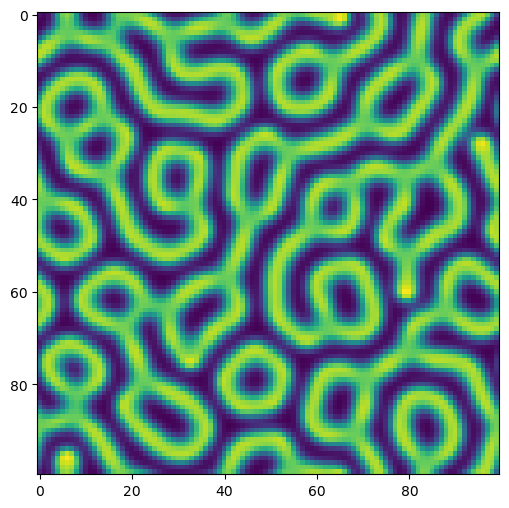

In [20]:
# Import William's solution
# from solutions.grayscott import GrayScott

## Create initial conditions
np.random.seed(0)
u_ic = 0.5 +  1.5 * np.random.random((100, 100))
v_ic = 1 - np.copy(u_ic)

## Run simulation
model = GrayScott(*u_ic.shape)
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)

## Check that our spectral code is working: the imaginary residual should be small
print(f"Imaginary residual is: {np.mean(np.abs(np.imag(np.array(sol))))}")
sol = np.real(sol)

plt.figure(figsize=(6, 6))
plt.imshow(sol[-1, ..., 1])

In [21]:
## Create an interactive plot using ipywidgets

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(sol[i, ..., 1])
    plt.show()



interact(
    plotter, 
    i=widgets.IntSlider(0, 0, len(sol) - 1, 1, layout=Layout(width='500px'))
)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=499), Output()), _…

<function __main__.plotter(i)>

#### Extras

William's code to run a parameter sweep and create a video of the changing solution as a function of the initial conditions.

In [ ]:
## Quasi-static parameter sweep
# 
# Compute the steady state solution for a range of parameters, and pass the solution
# to the solver as the initial condition for the next parameter value

du_vals = np.linspace(0.08, 0.5, 500)

model = GrayScott(*u_ic.shape, du=du_vals[0])
tpts, sol = model.solve([u_ic, v_ic], 0, 5000, 500)
all_u, all_v = [np.copy(sol[-1, ..., 0])], [np.copy(sol[-1, ..., 1])]

for i, du in enumerate(du_vals[1:]):
    if i % 50 == 0: print(i, flush=True)
    model = GrayScott(*u_ic.shape, du=du)
    tpts, sol = model.solve([all_u[-1], all_v[-1]], 0, 100, 10)
    all_u.append(sol[-1, ..., 0])
    all_v.append(sol[-1, ..., 1])
all_v = np.array(all_v)
all_u = np.array(all_u)


In [ ]:
vfield2 = np.copy(all_v)
vmin = np.percentile(vfield2, 1)
vmax = np.percentile(vfield2, 95)

for i in range(len(vfield2) - 1):
    
    
    out_path = "private_dump/turing/frame" + str(i).zfill(4) + ".png"

    plt.figure()
    #plt.imshow(vfield2[i], vmin=vmin, vmax=vmax)
    plt.imshow(vfield2[i]) # autoscale brightness

    ax = plt.gca()
    ax.set_axis_off()
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.set_aspect(1, adjustable='box')

    plt.savefig(out_path, bbox_inches='tight', pad_inches=0.0, dpi=300)
    plt.close()
